# Novel Information Visualization

***COMP47970 - Information Visualisation BD - 2024/25 Spring***

> - **Name:** Yu Du
> - **Date:** Apr. 30, 2025

In this final individual project on novel information visualization, I chose to continue using [Vega-Lite (specifically the Python version)](https://altair-viz.github.io) to achieve my goal. This decision was based on the fact that the diagram types and interaction categories supported by [Vega-Lite](https://vega.github.io/vega-lite/) had been proven very effective during the laboratory classes. Additionally, by combining Vega-Lite with Python’s data processing and logical expression capabilities, it becomes a very good choice. 

For this project, I chose [the Collection of Recipes Around the World dataset from Kaggle](https://www.kaggle.com/datasets/prajwaldongre/collection-of-recipes-around-the-world) as the basis for my visualization analysis. While there are many studies on food in general, there are relatively few visualizations specifically focused on recipes. This dataset provides a fascinating glimpse into the global culinary landscape, featuring a wide variety of recipes from diverse cultures and traditions. Therefore, it is highly suitable for the objectives of this task.

In this notebook, I will focus on the coding implementation of the novel information visualization and will provide the analysis in a separate document.

**Outline**
- [Understanding the Dataset](#1-understanding-the-dataset)
- [Data Analysis](#2-data-analysis)
    - [Recipe Distribution Analysis](#21-recipe-distribution-analysis)
    - [Analysis of the Relationship between Cooking Time and Calories](#22-analysis-of-the-relationship-between-cooking-time-and-calories)
    - [Analysis of the Relationship between Preparation Time and Servings](#23-analysis-of-the-relationship-between-preparation-time-and-servings)
    - [Ingredient Popularity Analysis](#24-ingredient-popularity-analysis)

In [ ]:
# Import necessary packages
import warnings
import ast
import random
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
from vega_datasets import data as vega_data
from collections import Counter
from wordcloud import WordCloud

# Set up the Altair renderer
alt.renderers.enable('html')

# Magic function
%matplotlib inline

# Read data from the csv data file
raw_data = pd.read_csv('./Receipes from around the world.csv')

***

## 1 Understanding the Dataset

In [77]:
# Disable warning output
warnings.filterwarnings('ignore')

# Extract the main features
columns_needed = ['cuisine', 'dietary_restrictions', 'cooking_time_minutes', 'prep_time_minutes', 'servings', 'calories_per_serving']
pre_analysis_data = raw_data[columns_needed]

# Set the maximum number of rows in Altair (to prevent errors caused by too much data)
alt.data_transformers.disable_max_rows()

# Set bar chart and histogram effect color
main_bar_color = '#8A8CBF'
hover_bar_color = '#4E659B'
main_hist_color = '#EFA484'
hover_hist_color = '#B6766C'

# Defining selection
hover = alt.selection_point(name="highlight", on="pointerover", empty=False)

# Configure public bar chart (with dynamic hover effect + rounded corners)
def bar_chart(column, title):
    base = alt.Chart(pre_analysis_data.reset_index().rename(columns={'index': '_id'})).mark_bar(
        cornerRadiusTopRight=5,
        cornerRadiusBottomRight=5
    ).encode(
        x=alt.X('count()', title='Count'),
        y=alt.Y(f'{column}:N', sort='-x', title=title),
        color=alt.condition(
            hover,
            alt.value(hover_bar_color),
            alt.value(main_bar_color)
            ),
        tooltip=[
            alt.Tooltip(f'{column}:N', title=title),
            alt.Tooltip('count()', title='Count')
            ]
    ).add_params(
        hover
    ).properties(
        width=300,
        height=200,
        title=f'{title} Distribution'
    ).interactive()
    
    return base

# Configure a public histogram (with dynamic hover effect + rounded corners)
def hist_chart(column, title):
    base = alt.Chart(pre_analysis_data.reset_index().rename(columns={'index': '_id'})).mark_bar(
        cornerRadiusTopLeft=5,
        cornerRadiusTopRight=5
    ).encode(
        x=alt.X(f'{column}:Q', bin=alt.Bin(maxbins=30), title=title),
        y=alt.Y('count()', title='Count'),
        color=alt.condition(
            hover, 
            alt.value(hover_hist_color), 
            alt.value(main_hist_color)
            ),
        tooltip=[
            alt.Tooltip(f'{column}:Q', bin=True, title=title), 
            alt.Tooltip('count()', title='Count')
            ]
    ).add_params(
        hover
    ).properties(
        width=300,
        height=200,
        title=f'{title} Distribution'
    ).interactive()
    
    return base

# Create each thumbnail
cuisine_bar = bar_chart('cuisine', 'Cuisine')
dietary_bar = bar_chart('dietary_restrictions', 'Dietary Restrictions')
cooking_hist = hist_chart('cooking_time_minutes', 'Cooking Time (minutes)')
prep_hist = hist_chart('prep_time_minutes', 'Preparation Time (minutes)')
servings_hist = hist_chart('servings', 'Servings')
calories_hist = hist_chart('calories_per_serving', 'Calories per Serving')

# Stitching thumbnails
upper = alt.hconcat(cuisine_bar, dietary_bar, spacing=10)
middle = alt.hconcat(cooking_hist, prep_hist, spacing=100)
lower = alt.hconcat(servings_hist, calories_hist, spacing=100)

# Combine into a grid
grid = alt.vconcat(upper, middle, lower).resolve_scale(
    x='independent',
    y='independent'
)

grid

alt.VConcatChart(...)

## 2 Data Analysis

### 2.1 Recipe Distribution Analysis

Since the values in the `cuisine` column are not standard country names, I created a transformation dictionary to convert them. This was necessary because only standardized country names can be mapped correctly onto the world map provided by a third-party organization.

In [97]:
# Disable warning output
warnings.filterwarnings('ignore')

# Extract and statistic the necessary features
cuisine_counts = raw_data['cuisine'].value_counts()

# Convert into DataFrame type
country_counts = cuisine_counts.reset_index()
country_counts.columns = ['country', 'recipe_count']

# Define a dictionary of standardized country names
adjective_to_country = {
    'Argentinian': 'Argentina',
    'Swedish': 'Sweden',
    'Japanese': 'Japan',
    'Nigerian': 'Nigeria',
    'Korean': 'South Korea',
    'Peruvian': 'Peru',
    'Ethiopian': 'Ethiopia',
    'Australian': 'Australia',
    'Thai': 'Thailand',
    'Mexican': 'Mexico',
    'French': 'France',
    'Polynesian': 'New Zealand',
    'Spanish': 'Spain',
    'Brazilian': 'Brazil',
    'Greek': 'Greece',
    'Italian': 'Italy',
    'Vietnamese': 'Vietnam',
    'American': 'United States',
    'Moroccan': 'Morocco',
    'Jamaican': 'Jamaica',
    'Lebanese': 'Lebanon',
    'Irish': 'Ireland',
    'Indian': 'India',
    'Chinese': 'China'
}

# Replace with standard country name
country_counts['country'] = country_counts['country'].map(adjective_to_country)

# Get world map TopoJSON
countries = alt.topo_feature('https://cdn.jsdelivr.net/npm/world-atlas@2/countries-110m.json', 'countries')

# Draw the background map
background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=800,
    height=400
).project('equirectangular')

# Define hover selection
hover = alt.selection_single(name="highlight", on='pointerover', empty='none', fields=['properties.name'])

# Draw a map with data
choropleth = alt.Chart(countries).mark_geoshape().encode(
    color=alt.condition(
        hover,
        alt.value('#8A8CBF'),
        alt.Color('recipe_count:Q', 
                  scale=alt.Scale(range=['#FCE5D3', '#F9D6BF', '#F5C6AB', '#F2B597', '#EFA484', '#C67152', '#9E462C', '#752410']), 
                  title='Number of Recipes'
                  )
    ),
    tooltip=[
         alt.Tooltip('country:N', title='Country'), 
         alt.Tooltip('recipe_count:Q', title='Recipe Count')
         ],
).transform_lookup(
    lookup='properties.name', 
    from_=alt.LookupData(country_counts, 'country', ['country', 'recipe_count'])
).add_selection(
    hover
).properties(
    title='Recipe World Map',
    width=800,
    height=400
).project('equirectangular')

# Composite the final image
final_chart = background + choropleth

final_chart

alt.LayerChart(...)

### 2.2 Analysis of the Relationship between Cooking Time and Calories

In this section, it was necessary to pre-process the data by converting the `ingredients` column from string type to list type; otherwise, it would not be possible to accurately count the number of ingredients.

In [100]:
# Disable warning output
warnings.filterwarnings('ignore')

# Extract needed columns
columns_needed = ['recipe_name', 'cuisine', 'ingredients', 'cooking_time_minutes', 'calories_per_serving']
analysis_data = raw_data[columns_needed]

# Process the ingredients column (parse from a string into a list, if it is already a list, you can skip it)
analysis_data['ingredients'] = analysis_data['ingredients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Add a new column ingredients_count to indicate the number of ingredients
analysis_data['ingredients_count'] = analysis_data['ingredients'].apply(len)

# Define hover selection
hover = alt.selection_single(name="highlight", on='pointerover', empty='none', fields=['recipe_name'])

# Draw a scatter plot
scatter_plot = alt.Chart(analysis_data).mark_circle().encode(
    x=alt.X('cooking_time_minutes:Q', title='Cooking Time (minutes)', axis=alt.Axis(grid=False)),
    y=alt.Y('calories_per_serving:Q', title='Calories per Serving', axis=alt.Axis(grid=False)),
    size=alt.Size('ingredients_count:Q', title='Number of Ingredients', scale=alt.Scale(range=[10, 300])),
    color=alt.condition(
        hover,
        alt.value('#4E659B'),
        alt.Color('ingredients_count:Q', 
                  scale=alt.Scale(range=['#FADFE2', '#F5D6DA', '#F1CDD3', '#ECC4CC', '#E7BCC6', '#C07589', '#9A3F5A', '#731736']), 
                  title='Number of Ingredients'
                  )
    ),
    tooltip=[
        alt.Tooltip('recipe_name:N', title='Recipe Name'),
        alt.Tooltip('cuisine:N', title='Cuisine'),
        alt.Tooltip('cooking_time_minutes:Q', title='Cooking Time (minutes)'),
        alt.Tooltip('calories_per_serving:Q', title='Calories per Serving'),
        alt.Tooltip('ingredients_count:Q', title='Ingredients Count')
        ]
).add_selection(
    hover
).properties(
    title='Cooking Time vs Calories per Serving',
    width=600,
    height=400
).interactive()

scatter_plot

alt.Chart(...)

### 2.3 Analysis of the Relationship between Preparation Time and Servings

In [107]:
# Disable warning output
warnings.filterwarnings('ignore')

# Extract needed columns
columns_needed = ['recipe_name', 'cuisine', 'prep_time_minutes', 'servings']
analysis_data = raw_data[columns_needed]

# Define hover selection
hover = alt.selection_single(name="highlight", on='pointerover', empty='none', fields=['recipe_name'])

# Draw a basic scatter plot
points = alt.Chart(analysis_data).mark_circle(size=80, opacity=0.6).encode(
    x=alt.X('prep_time_minutes:Q', title='Preparation Time (minutes)', axis=alt.Axis(grid=False)),
    y=alt.Y('servings:Q', title='Number of Servings', axis=alt.Axis(grid=False)),
    color=alt.condition(
        hover,
        alt.value('#FEEACA'),
        alt.value('#846AAE')
    ),
    tooltip=[
        alt.Tooltip('recipe_name:N', title='Recipe Name'),
        alt.Tooltip('cuisine:N', title='Cuisine'),
        alt.Tooltip('prep_time_minutes:Q', title='Prep Time (min)'),
        alt.Tooltip('servings:Q', title='Servings')
    ]
).add_selection(hover)

# Regression line + predicted values
regression = alt.Chart(analysis_data).transform_regression(
    'prep_time_minutes', 'servings', method='linear'
).transform_calculate(
    lower='datum.servings - 0.5',
    upper='datum.servings + 0.5'
)

# Confidence interval shading
ci_band = regression.mark_area(
    color='#F2B597',
    opacity=0.3
).encode(
    x='prep_time_minutes:Q',
    y='lower:Q',
    y2='upper:Q'
)

# Regression solid line
regression_line = regression.mark_line(
    color='#9E462C',
    size=3
).encode(
    x='prep_time_minutes:Q',
    y='servings:Q'
)

# Combine chart
final_chart = (points + ci_band + regression_line).properties(
    width=600,
    height=400,
    title='Relationship between Preparation Time and Servings (with Confidence Interval)'
).interactive()

final_chart

alt.LayerChart(...)

### 2.4 Ingredient Popularity Analysis

In this section, I chose to use another Python package to achieve the goal. I initially tried using the `altair` package (the Python implementation of Vega-Lite), but found that the visual effects were not very satisfactory. Before visualization, I added a pre-processing step: I merged all the ingredients of each recipe together without repetition, making it easier for follow-up statistical analysis. Additionally, I added a small function to randomly select colors and apply them to the word cloud.

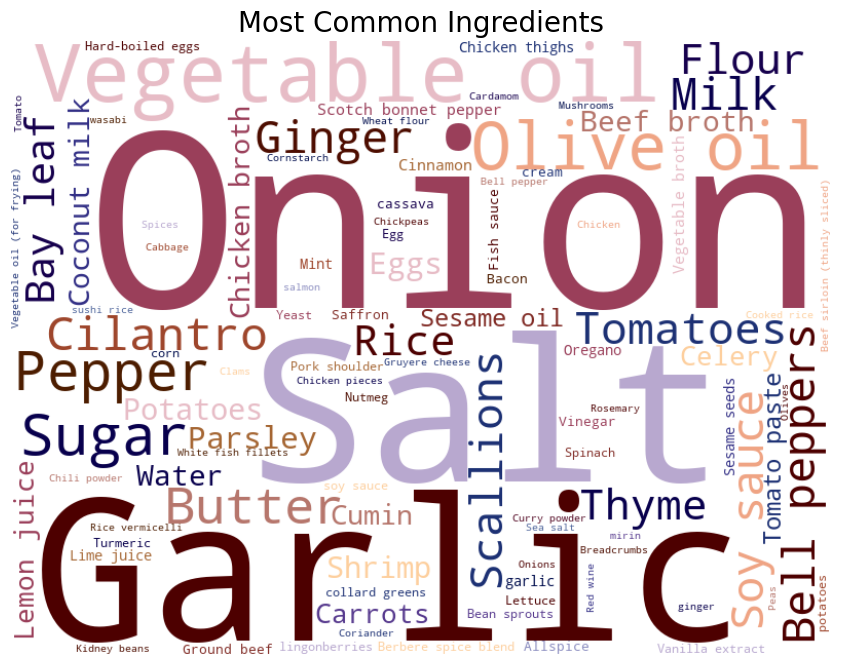

In [ ]:
# Disable warning output
warnings.filterwarnings('ignore')

# Extract needed columns
ingredients = raw_data['ingredients'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Expand all ingredients and count their frequency
all_ingredients = [ingredient for ingredients_list in ingredients for ingredient in ingredients_list]
ingredient_counts = Counter(all_ingredients)

# Preparing a custom color list
custom_colors = ['#000D4D', '#08004D', '#16004D', '#4D001C', '#4D1D00', '#4D0D00', '#4D0000', 
                 '#1D3174', '#333086', '#573A8E', '#9A3F5A', '#A56633', '#9E462C', '#812C26', 
                 '#4E659B', '#8A8CBF', '#B8A8CF', '#E7BCC6', '#FDCF9E', '#EFA484', '#B6766C']

# Create a method to randomly select a color
def hex_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(custom_colors)

# Generate WordCloud object
wordcloud = WordCloud(
    width=800,
    height=600,
    background_color='white',
    color_func=hex_color_func,
    max_words=100,        
    relative_scaling=0.5, 
    random_state=42       
).generate_from_frequencies(ingredient_counts)

# Display word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Ingredients', fontsize=20)
plt.show()

**End of the Notebook**